In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from scipy.special import psi, polygamma
import random
import tensorflow as tf
from matplotlib import pyplot as plt

tf.random.set_seed(0)

In [2]:
from keras.models import Sequential
from keras.models import Model
from keras import regularizers
from keras.layers import Input, Dense, Dropout, Activation, Lambda
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.layers import LSTM, GRU, SimpleRNN

In [3]:
#This function is used to encode a vector as follows:
'''
when the vector element == 'normal', it will be transformed to 1 and to 0 if not
'''
def encoding(y):
  enc = [1 if y[i]=='normal' else 0 for i in range(len(y))]
  return pd.DataFrame(enc)

##**Load the Data**

In [4]:
def load_data(path_train, path_test):
  train = pd.read_csv(path_train)  #load the train data
  test = pd.read_csv(path_test)  #load the test data

  train_normal = pd.DataFrame(train[train['connection_type'] == 'normal'])   #train samples which have normal as label
  train_attack = pd.DataFrame(train[train['connection_type'] != 'normal'])   #train samples which have attack as label
  test_normal = pd.DataFrame(test[test['connection_type'] == 'normal'])      #test samples which have normal as label 
  test_attack = pd.DataFrame(test[test['connection_type'] != 'normal'])      #test samples which have attack as label

  nbr_of_normal_train_samples = 10000  #number of the normal samples that we will work with in the train data
  nbr_of_attack_train_samples = 10000  #number of the attack samples that we will work with in the train data
  nbr_of_normal_test_samples = 2500   #number of the normal samples that we will work with in the test data
  nbr_of_attack_test_samples = 2500    #number of the attack samples that we will work with in the test data
  
  tf.random.set_seed(0)
  train_normal = pd.DataFrame(train_normal[:nbr_of_normal_train_samples])
  train_attack = pd.DataFrame(train_attack[:nbr_of_attack_train_samples])
  test_normal = pd.DataFrame(test_normal[:nbr_of_normal_test_samples])
  test_attack = pd.DataFrame(test_attack[:nbr_of_attack_test_samples])

  #concatenate the normal samples and the attack samples into a single data with the desired number of normal samples and attack samples for both train and test
  train = pd.DataFrame(pd.concat([train_normal,train_attack]))   
  test = pd.DataFrame(pd.concat([test_normal,test_attack]))

  train = train.reset_index(drop = True)   #reset index for the train data
  test = test.reset_index(drop = True)     #reset index for the test data

  #split the train and test into features data and labels
  x_train = pd.DataFrame(train.iloc[:,:41])
  y_train = pd.Series(train.iloc[:,41])
  x_test = pd.DataFrame(test.iloc[:,:41])
  y_test = pd.Series(test.iloc[:,41])

  #use the command 'get_dummies' to eliminate the categorical features
  x_train = pd.get_dummies(x_train)
  x_test = pd.get_dummies(x_test)

  #join x_train and x_test as both of them they haven't the same shape after 'get_dummies' command
  x_train , x_test = x_train.align(x_test, join = 'inner', axis = 1) 

  #encode both y_train and y_test 
  y_train = encoding(y_train)
  y_test = encoding(y_test)

  #Normalize the data
  scaler = Normalizer().fit(x_train)
  x_train = scaler.transform(x_train)

  scaler = Normalizer().fit(x_test)
  x_test = scaler.transform(x_test)

  #transform y_train and y_test into arrays
  y_train = np.array(y_train)
  y_test = np.array(y_test)

  return (x_train , y_train) , (x_test , y_test)

##**Transformtions**

In [5]:
def transformation(input_dim, h_dim,):
  input = Input(shape=(input_dim,))
  layer1 = Dense(h_dim, use_bias = False, activation='relu')(input)
  output = Dense(input_dim, use_bias = False, activation='sigmoid')(layer1)

  # this model maps an input to its reconstruction
  transformer = Model(input, output)
  return transformer

In [6]:
def create_transformations_list(input_dim, h_dim, num_trans):
  trans_list = []
  for i in range(num_trans):
    trans = transformation(input_dim ,h_dim[i])
    trans_list.append(trans)
  return trans_list 

##**Encoding**

In [7]:
from keras.layers import Input, Dense
from keras.models import Model

def AutoEncoder(input_shape):
  input = Input(shape=(input_shape,))
  layer1 = Dense(128, use_bias = False, activation='relu')(input)
  layer2 = Dense(64, use_bias = False, activation='relu')(layer1)
  encoded = Dense(32, use_bias = False, activation='relu')(layer2)  # encoding_dim = 32
  layer3 = Dense(64, use_bias = False, activation='relu')(encoded)
  layer4 = Dense(128, use_bias = False, activation='relu')(layer3)
  decoded = Dense(input_shape, use_bias = False, activation='relu')(layer4)

  # this model maps an input to its reconstruction
  autoencoder = Model(input, decoded)
  return autoencoder

In [8]:
def classifier(input_shape,lstm_output_size,nbr_of_classes):
  model = Sequential()
  model.add(Convolution1D(128, 3, padding="same",activation="relu",input_shape=(input_shape, 1)))
  model.add(MaxPooling1D(pool_size=3))
  model.add(LSTM(lstm_output_size))
  model.add(Dropout(0.1))
  model.add(Dense(nbr_of_classes, activation="softmax"))
  print(model.summary())
  return model

##**Experiments**

In [9]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
def roc_pr_curve_data(scores, labels):
    scores = scores.flatten()
    labels = labels.flatten()

    scores_pos = scores[labels == 1]
    scores_neg = scores[labels != 1]

    truth = np.concatenate((np.zeros_like(scores_neg), np.ones_like(scores_pos)))
    preds = np.concatenate((scores_neg, scores_pos))
    fpr, tpr, roc_thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    print("roc_auc",roc_auc)

    # pr curve where "normal" is the positive class
    precision_norm, recall_norm, pr_thresholds_norm = precision_recall_curve(truth, preds)
    pr_auc_norm = auc(recall_norm, precision_norm)
    print("pr_auc_norm where normal is the positive class",pr_auc_norm)

    # pr curve where "anomaly" is the positive class
    precision_anom, recall_anom, pr_thresholds_anom = precision_recall_curve(truth, -preds, pos_label=0)
    pr_auc_anom = auc(recall_anom, precision_anom)
    print("pr_auc_norm where anomaly is the positive class",pr_auc_anom)

In [10]:
#load the data
path_train = "train_kdd.csv"
path_test = "test_kdd.csv"
(x_train, y_train) , (x_test, y_test) = load_data('/content/train_kdd_nsl.csv', '/content/test_kdd_nsl.csv')

In [11]:
import os
import csv
from collections import defaultdict
from glob import glob
from multiprocessing import Manager, freeze_support, Process

In [12]:
def training_class_nsl_kdd(x_train,y_train,x_test,y_test,single_class_ind):
  print("Class ",single_class_ind)
  tf.random.set_seed(0)

  #Transform the data
  print('Start of transformations for class',single_class_ind)
  x_train_task = x_train[y_train.flatten() == single_class_ind]
  num_trans = 10
  h_dim = [10,20,30,40,50,60,70,80,90,100]
  transformations_inds = np.tile(np.arange(num_trans), len(x_train_task))
  transformations_list = create_transformations_list(x_train_task.shape[1], h_dim, num_trans)
  data_each_transformation = []
  for transformation in transformations_list:
    print('transformation ', transformations_list.index(transformation))
    transformation.compile(loss="mse", optimizer="adamax",metrics=['accuracy'])
    transformation.fit(x_train_task, x_train_task, batch_size=64, epochs= 10) 
    data_trans = transformation.predict(x_train_task)
    data_each_transformation.append(data_trans)
  data_transformed = pd.concat([pd.DataFrame(data_each_transformation[i]) for i in range(len(data_each_transformation))])
  data_transformed = data_transformed.reset_index(drop = True)
  data_organised = []
  for i in range(len(x_train_task)):
    data_trans_k = data_transformed.iloc[i::len(x_train_task),:]
    data_organised.append(data_trans_k)
  x_train_task_transformed = pd.concat([pd.DataFrame(data_organised[i]) for i in range(len(data_organised))])
  x_train_task_transformed = x_train_task_transformed.reset_index(drop = True)
  print('End of transformations for class',single_class_ind)


  #Encode the data
  print('Start of Encoding for class',single_class_ind)
  autoencoder = AutoEncoder(x_train_task_transformed.shape[1])
  autoencoder.compile(optimizer='adam', loss='mse')
  autoencoder.fit(x_train_task_transformed, x_train_task_transformed, epochs=3, batch_size=64)
  x_train_task_encoded = autoencoder.predict(x_train_task_transformed)
  print('End of Encoding for class',single_class_ind)

  #Create and train the classifier
  cls = classifier(x_train_task_transformed.shape[1],70,len(h_dim))
  cls.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
  cls.fit(x=x_train_task_encoded, y=to_categorical(transformations_inds),
            batch_size=64, epochs= 50)    #N_EPOCHS
  observed_dirichlet_list = []         
  for t_ind in range(num_trans):
    observed_data_transformed = data_each_transformation[t_ind]
    observed_data_autoencoded = autoencoder.predict(observed_data_transformed)
    observed_dirichlet = cls.predict(observed_data_autoencoded) 
    observed_dirichlet_list.append(observed_dirichlet)
  return observed_dirichlet_list

In [13]:
print('NSL-KDD Data Set')
(x_train, y_train), (x_test, y_test) = load_data('/content/train_kdd_nsl.csv', '/content/test_kdd_nsl.csv')
observed_dirichlet_0 = training_class_nsl_kdd(x_train,y_train,x_test,y_test,0)
observed_dirichlet_1 = training_class_nsl_kdd(x_train,y_train,x_test,y_test,1)

NSL-KDD Data Set
Class  0
Start of transformations for class 0
transformation  0
Epoch 1/10
157/157 [==============================] - 2s 4ms/step - loss: 0.2376 - accuracy: 0.0221
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 0.1804 - accuracy: 0.6535
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0813 - accuracy: 0.6343
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0279 - accuracy: 0.6343
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0132 - accuracy: 0.6343
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0082 - accuracy: 0.6343
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0059 - accuracy: 0.6343
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0047 - accuracy: 0.6343
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 0.0040 - accuracy: 0.6343
Epoch 10/10
313/313

In [14]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

num_tran = 10
CM_0 = []
CM_1 = []
for t_ind in range(num_tran):
  df_i = pd.DataFrame(observed_dirichlet_0[t_ind])
  corr_matrix_i = df_i.corr()
  CM_0.append(corr_matrix_i)
for t_ind in range(num_tran):
  df_i = pd.DataFrame(observed_dirichlet_1[t_ind])
  corr_matrix_i = df_i.corr()
  CM_1.append(corr_matrix_i)

Class 0, Transformation: 0


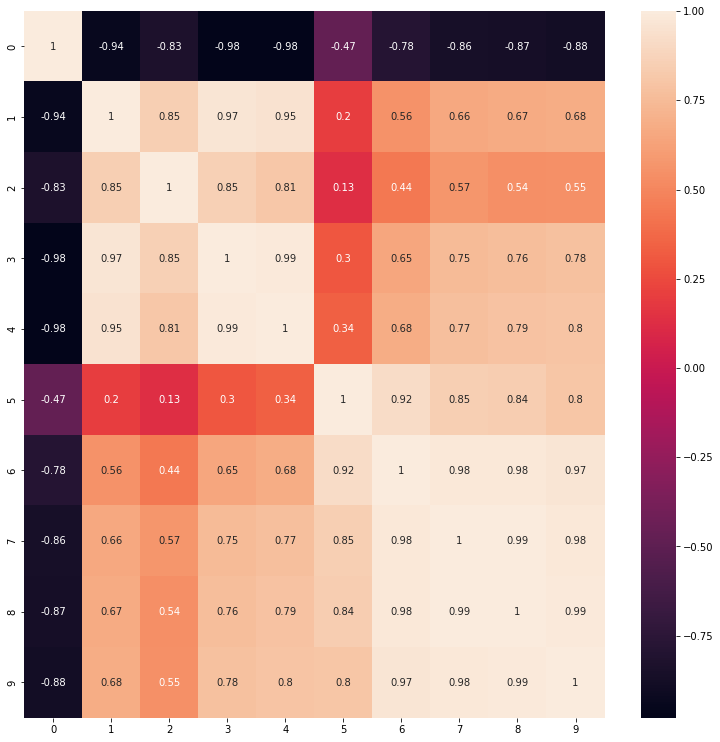

Class 0, Transformation: 1


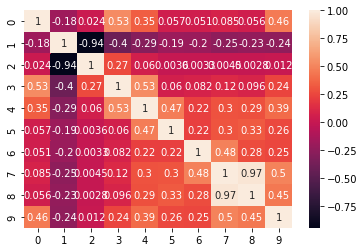

Class 0, Transformation: 2


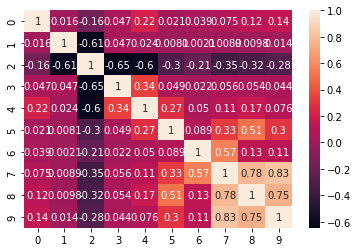

Class 0, Transformation: 3


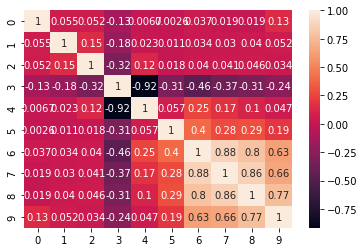

Class 0, Transformation: 4


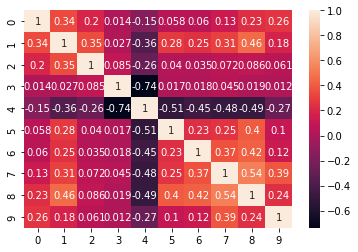

Class 0, Transformation: 5


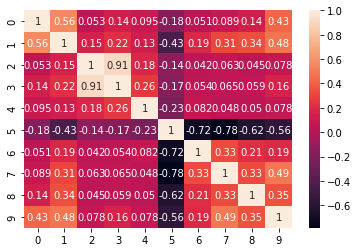

Class 0, Transformation: 6


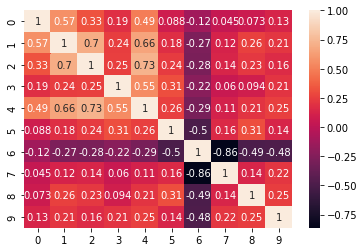

Class 0, Transformation: 7


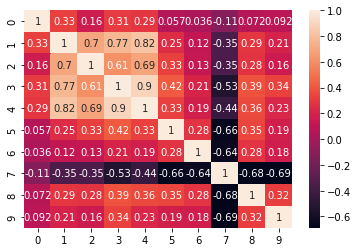

Class 0, Transformation: 8


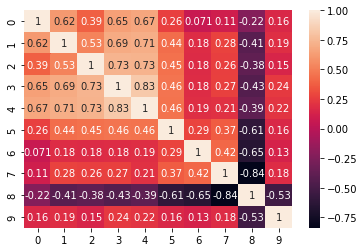

Class 0, Transformation: 9


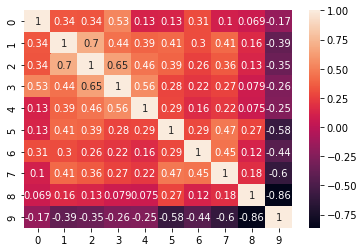

Class 1, Transformation: 0


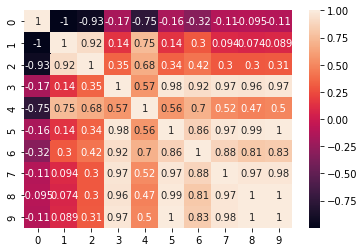

Class 1, Transformation: 1


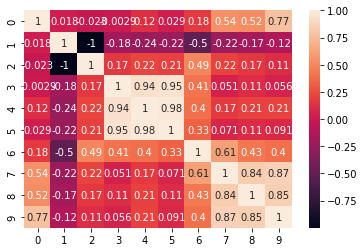

Class 1, Transformation: 2


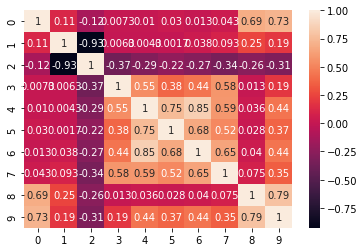

Class 1, Transformation: 3


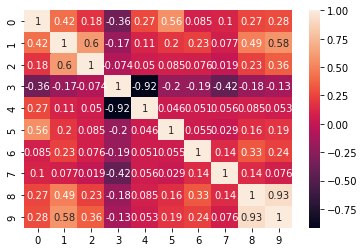

Class 1, Transformation: 4


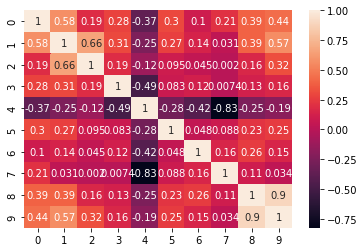

Class 1, Transformation: 5


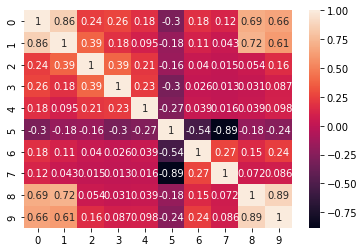

Class 1, Transformation: 6


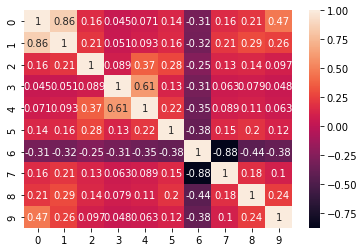

Class 1, Transformation: 7


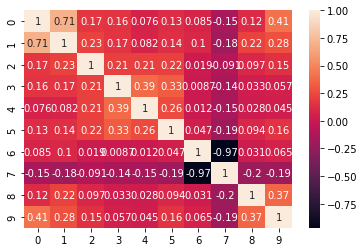

Class 1, Transformation: 8


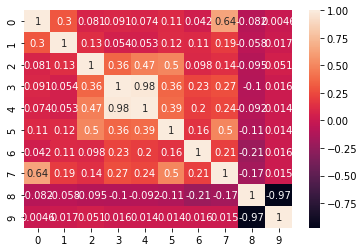

Class 1, Transformation: 9


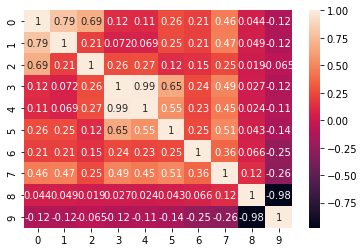

In [17]:
plt.figure(figsize=(13,13))
for t_ind in range(num_tran):
  print('Class 0, Transformation:',t_ind)
  sn.heatmap(CM_0[t_ind], annot=True)
  plt.show()
for t_ind in range(num_tran):
  print('Class 1, Transformation:',t_ind)
  sn.heatmap(CM_1[t_ind], annot=True)
  plt.show()